In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [28]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


## Define the cases

In [29]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test145"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d0918/Measure_MAT/Test145_E_d60_R_H150_T175_R00.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'ConversionOffset', 'DefaultData', 'MP3Filtered', 'MP3RawValue', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test145
   - testType: E
   - repeatType: N
   - useTest: nan
   - fSampling: 50.0
   - calibrationFile: Test145
   - depthAtWM: 0.604
   - depthAtMPL: 0.571
   - waveType: Regular 
   - waveAmplitude: 0.15
   - wavePeriod: 1.75
   - focusingLocation: nan
   - remarks: !! Start of Test Campaign !!
=== End of Test Properties ===



In [30]:
testName2 = "Test259"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1006/Measure_MAT/Test259_M_d60_R_H150_T175_R00.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test259
   - testType: MPL
   - repeatType: N
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.605
   - depthAtMPL: 0.572
   - waveType: Regular
   - waveAmplitude: 0.15
   - wavePeriod: 1.75
   - focusingLocation: nan
   - remarks: Empty = Test145, GP1, GP2, GP3
=== End of Test Properties ===



In [31]:
testName_peaks = 'Test259'

## Extract Default Dataset and Set Tare

In [32]:
ds1 = loaded_mat1["DefaultData"]
fSampling1 = loaded_mat1["TestProperties"]['fSampling']
testProp1 = loaded_mat1["TestProperties"]
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
fSampling2 = loaded_mat2["TestProperties"]['fSampling']
testProp2 = loaded_mat2["TestProperties"]
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 2
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3RawValue'}
{'reference': 'MP3Filtered'}


## Shift time coord to overlap signals

### Based on max-value

In [33]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

### Based on cross-correlation

In [34]:
def sync_signals_crosscorr(ds1, fSampling1, ds2, fSampling2, tmin, tmax, wg='WG01'):
    """Sync the signals using cross-correlation for the given wave gauge."""
    
    ds1_cut = ds1[wg].sel(Time=slice(tmin, tmax))
    ds2_cut = ds2[wg].sel(Time=slice(tmin, tmax))

    # time_lag = skb.postprocess.sync_signals_crosscorr_downsample(
    time_lag_maxCorr, time_lag_mat = skb.postprocess.sync_signals_crosscorr_upsample(
        ds1_cut, fSampling1, 
        ds2_cut, fSampling2, plotflag=True
    )

    return time_lag_maxCorr, time_lag_mat

Peaks in cross-corr: [-4.67333984 -2.93164062 -1.1875      0.55615234]


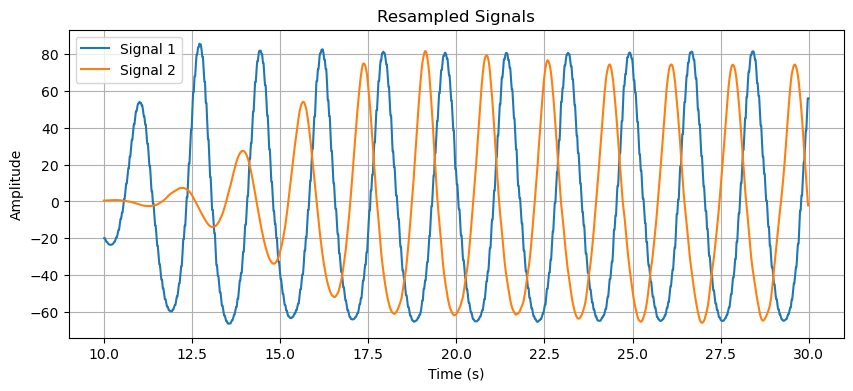

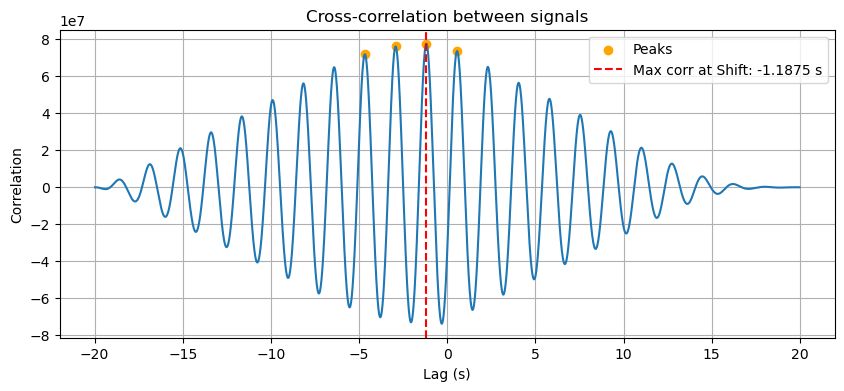

Shifting ds2 by -2.931640625


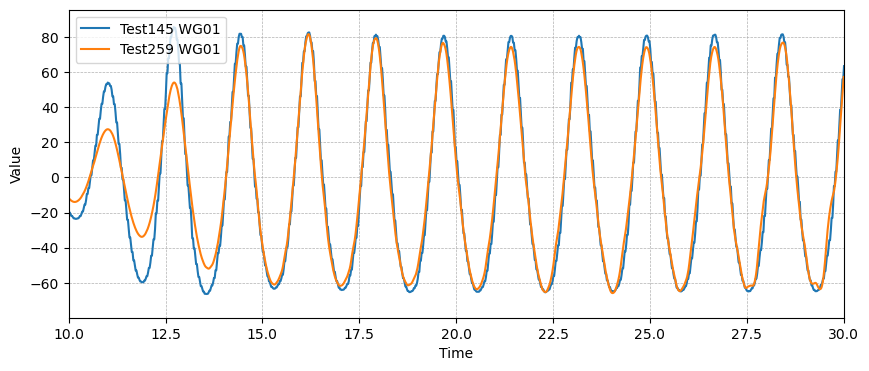

In [35]:
# # Shift ds2 time to align max of WG01
# # Can change to any other probe as needed

# # Using max-value
# ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=0, tmax=22)
# tShift = ds1_max_idxtime['WG01'].values - ds2_max_idxtime['WG01'].values

# Using cross-correlation
tShift_maxCorr, tShift_array = sync_signals_crosscorr(
    ds1, fSampling1, ds2, fSampling2, 
    tmin=10, tmax=30, wg = 'WG01' )
# tShift = tShift_maxCorr
tShift = tShift_array[1]

ds2 = ds2.assign_coords(Time=ds2['Time'] + tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

# Post shifting comparison plots
tmin = 10
tmax = 30

fig, ax = plt.subplots(figsize=(10,4))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.set_xlim(tmin, tmax)
set_min_plot_prop(ax)
plt.show()


## Get LED on off indices

In [36]:
skb.postprocess.update_LED_transition_indices(ds1)
skb.postprocess.update_LED_transition_indices(ds2)

print("DS1 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds1.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds1.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds1.attrs["LED_time_1_to_0"] - ds1.attrs["LED_time_0_to_1"]:.4f}')

print("\nDS2 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds2.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds2.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds2.attrs["LED_time_1_to_0"] - ds2.attrs["LED_time_0_to_1"]:.4f}')

No LED transitions found in 'LED-chan100' data.
DS1 LED Transition Indices:
LED_time_0_to_1 = 0.0000
LED_time_1_to_0 = 0.0000
dt = 0.0000

DS2 LED Transition Indices:
LED_time_0_to_1 = 5.2573
LED_time_1_to_0 = 11.5010
dt = 6.2436


## Load peaks

In [37]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/AllTest_log"
peaks_file_name = "log_videos_peak_regular.xlsx"

peaks_file = pd.ExcelFile(f"{data_folder}/{peaks_file_name}")
df = pd.read_excel(peaks_file, sheet_name='Sheet1')

# pprint(df.head())

In [38]:
testpeaks = df[df['Test_ID'] == testName_peaks]
# print(testpeaks)

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
pprint(testpeaks_LED_on); print()

tShift_peaks = ds2.attrs["LED_time_0_to_1"] - testpeaks_LED_on.values[0]
pprint(f"Shifting video peaks by {tShift_peaks}"); print()

flumeBottom_to_MPLBottom = 3 #mm
depthAtMPL = loaded_mat2['TestProperties']['depthAtMPL'] 

pprint(testpeaks.head()); print()
testpeaks.loc[:,'time_s'] = testpeaks['time_s'] + tShift_peaks

pprint(testpeaks.head()); print()

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
testpeaks_LED_off = testpeaks[testpeaks['event_type']=='LED_off']['time_s']
testpeaks_peaks = testpeaks[testpeaks['event_type'] == 'peak']
testpeaks_peaks.loc[:, 'value'] = testpeaks_peaks['value'] - depthAtMPL*1000 + flumeBottom_to_MPLBottom


pprint(testpeaks_peaks.head())

403    9.426
Name: time_s, dtype: float64

'Shifting video peaks by -4.168680625'

     Test_ID event_type  event_id  time_s  value
403  Test259     LED_on       1.0   9.426      1
404  Test259    LED_off       1.0  15.682      0
405  Test259       peak       1.0  21.788    670
406  Test259       peak       2.0  23.557    675
407  Test259       peak       3.0  25.292    675

     Test_ID event_type  event_id     time_s  value
403  Test259     LED_on       1.0   5.257319      1
404  Test259    LED_off       1.0  11.513319      0
405  Test259       peak       1.0  17.619319    670
406  Test259       peak       2.0  19.388319    675
407  Test259       peak       3.0  21.123319    675

     Test_ID event_type  event_id     time_s  value
405  Test259       peak       1.0  17.619319    101
406  Test259       peak       2.0  19.388319    106
407  Test259       peak       3.0  21.123319    106
408  Test259       peak       4.0  22.891319    111
409  Test259       peak       5.0  24.626319    1

## Plot signals

### WM Probe

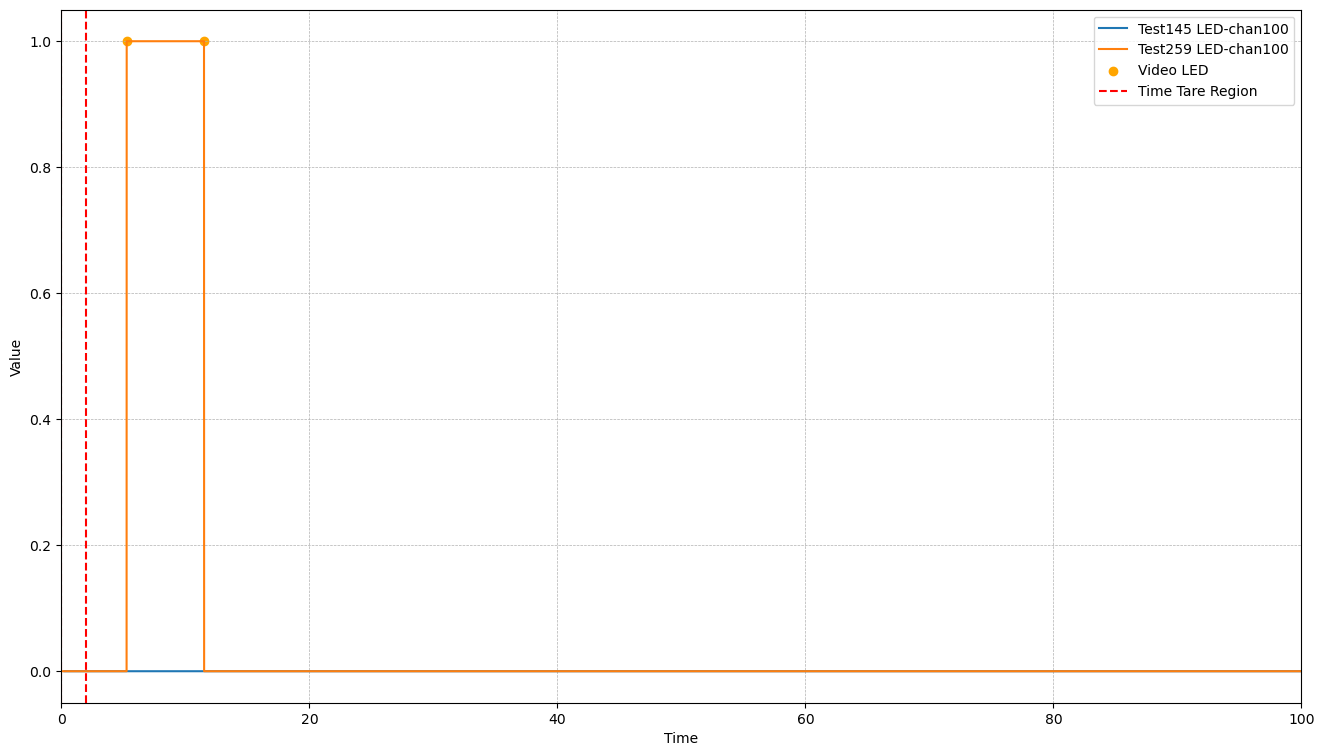

In [39]:
xmin = 0
xmax = 100


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label=f"{testName1} WM")
# ds2['WM'].plot(linestyle='-', label=f"{testName2} WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['LED-chan100'].plot(linestyle='-', label=f"{testName1} LED-chan100")
ds2['LED-chan100'].plot(linestyle='-', label=f"{testName2} LED-chan100")
plt.scatter([testpeaks_LED_on.values, testpeaks_LED_off.values], [1, 1], 
    color = 'orange',label = 'Video LED')
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

### WG01 - WG03

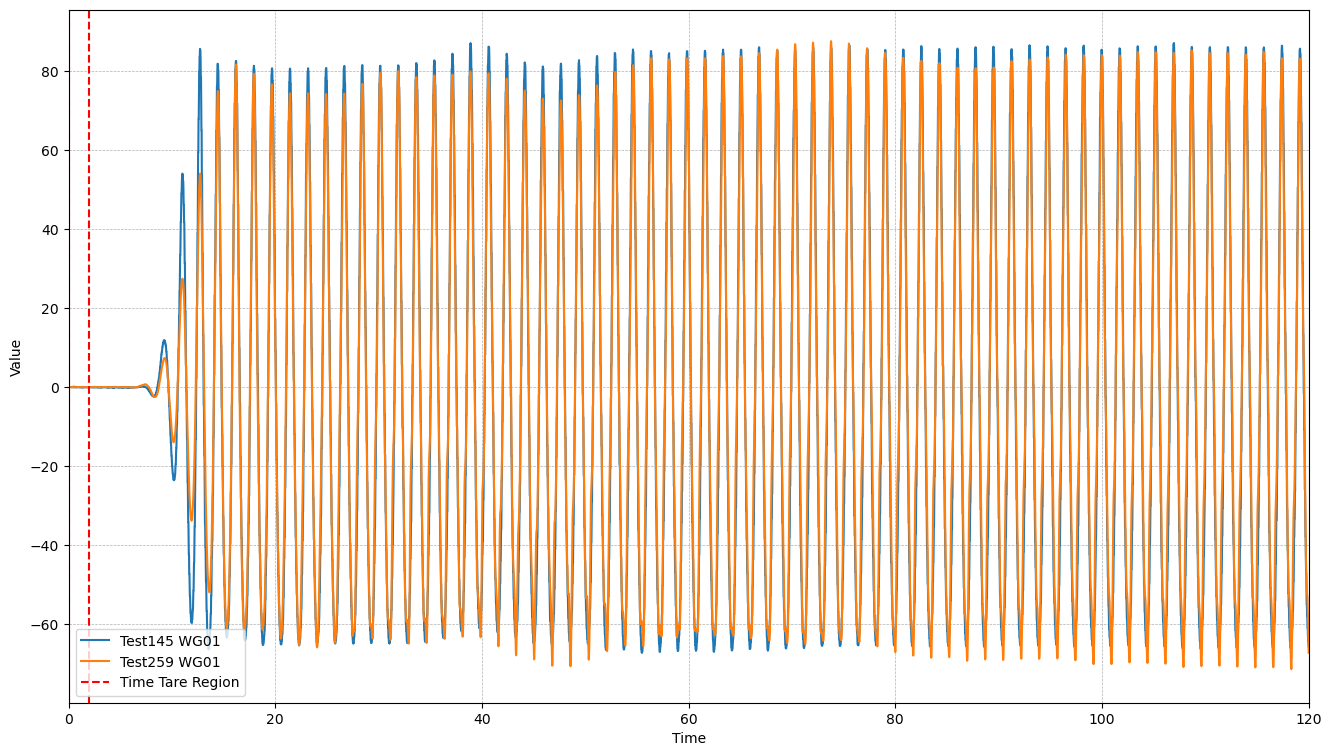

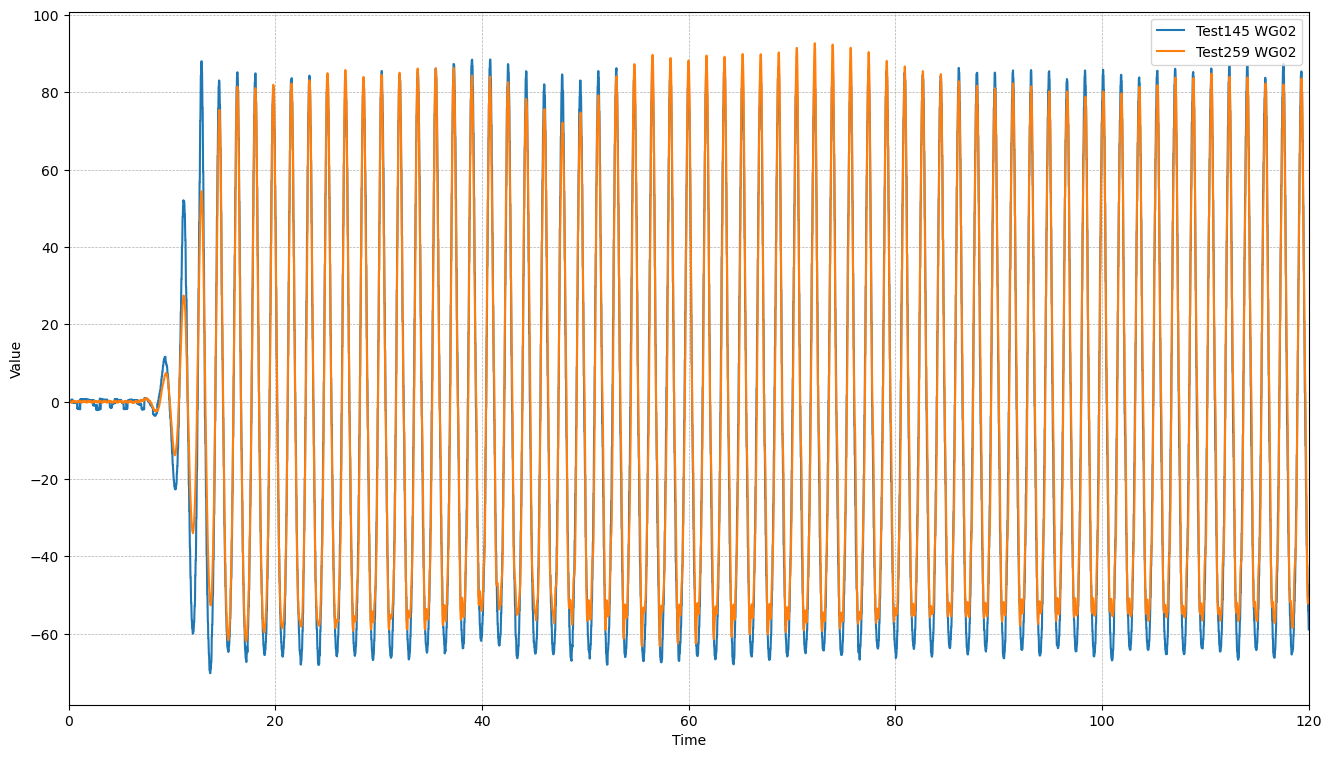

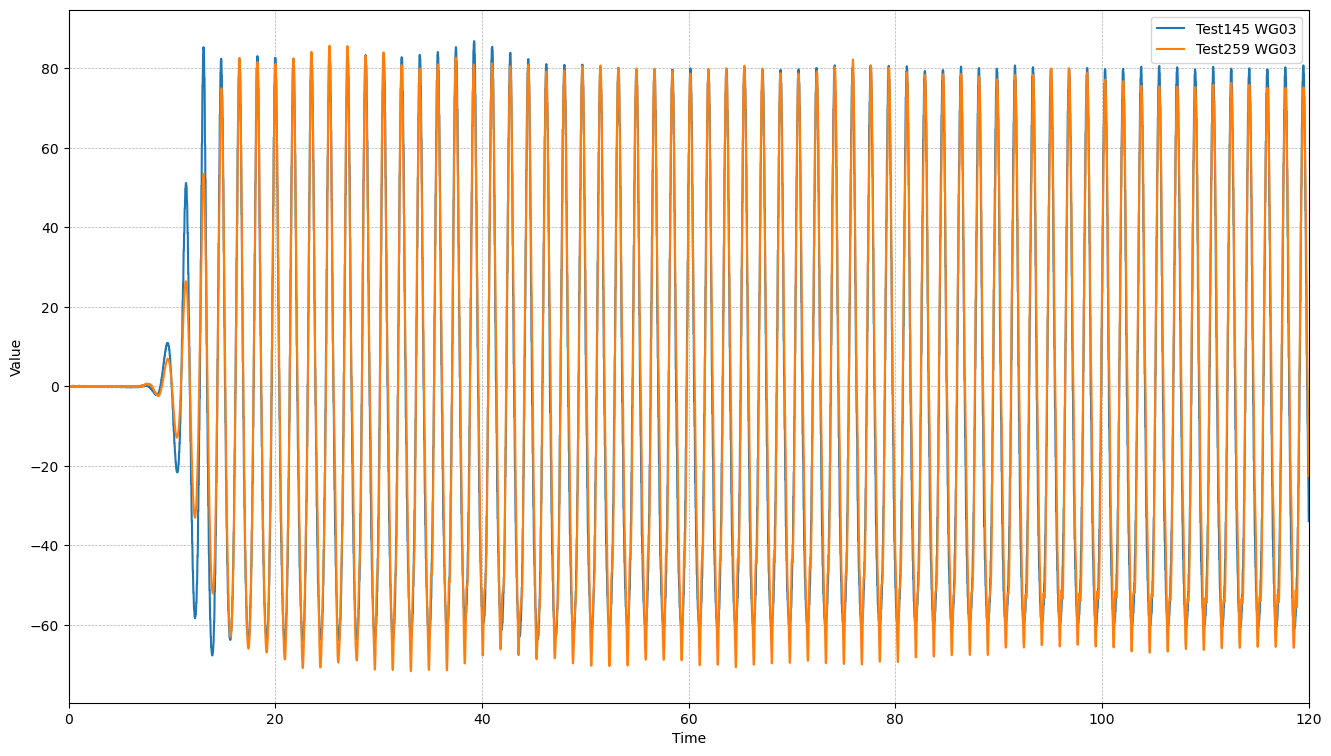

In [40]:
xmin = 0
xmax = 120

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG02'].plot(linestyle='-', label=f"{testName1} WG02")
ds2['WG02'].plot(linestyle='-', label=f"{testName2} WG02")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG03'].plot(linestyle='-', label=f"{testName1} WG03")
ds2['WG03'].plot(linestyle='-', label=f"{testName2} WG03")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG04 - WG06

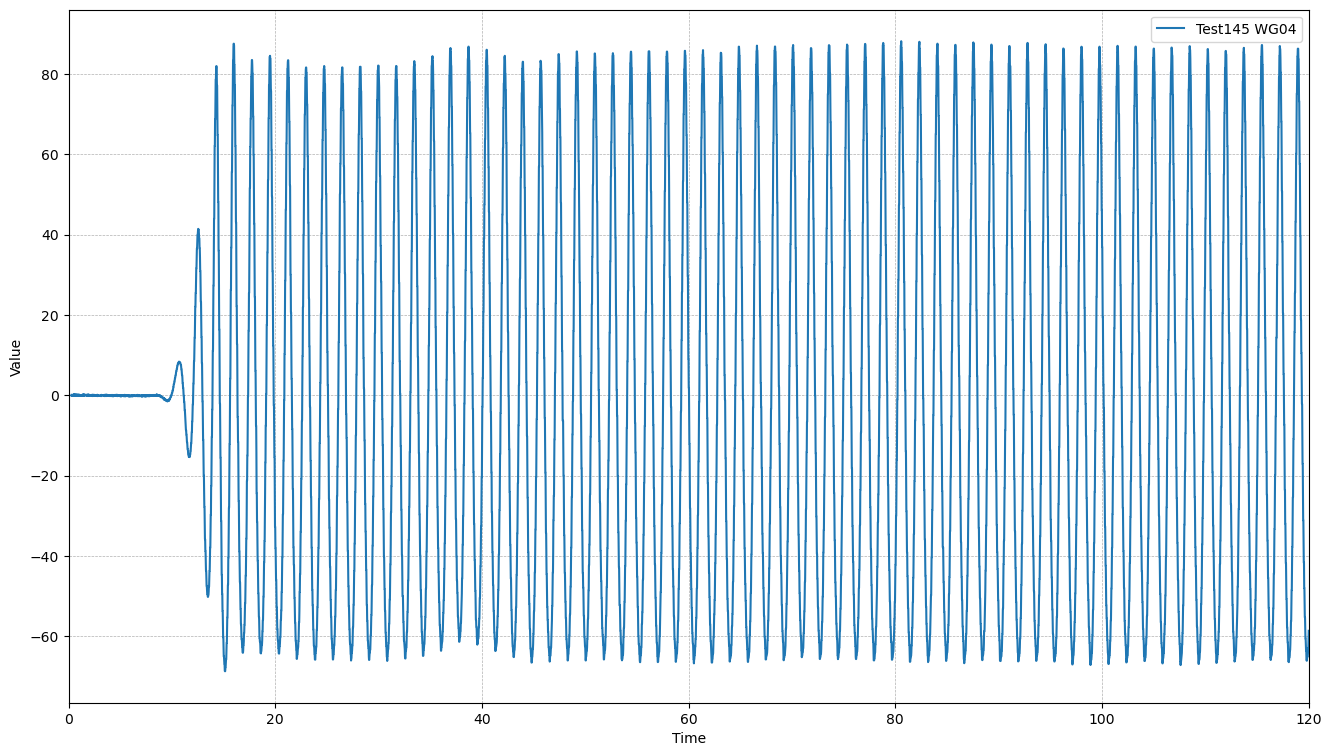

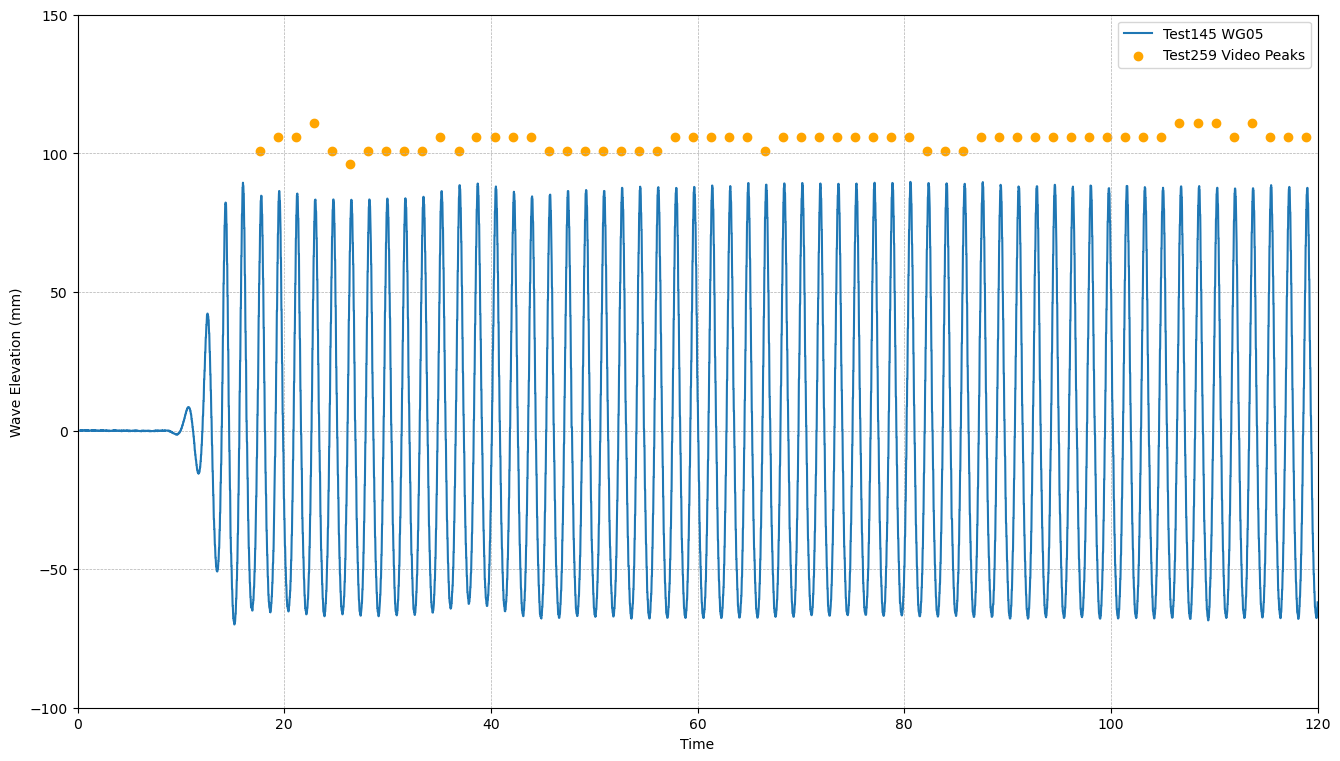

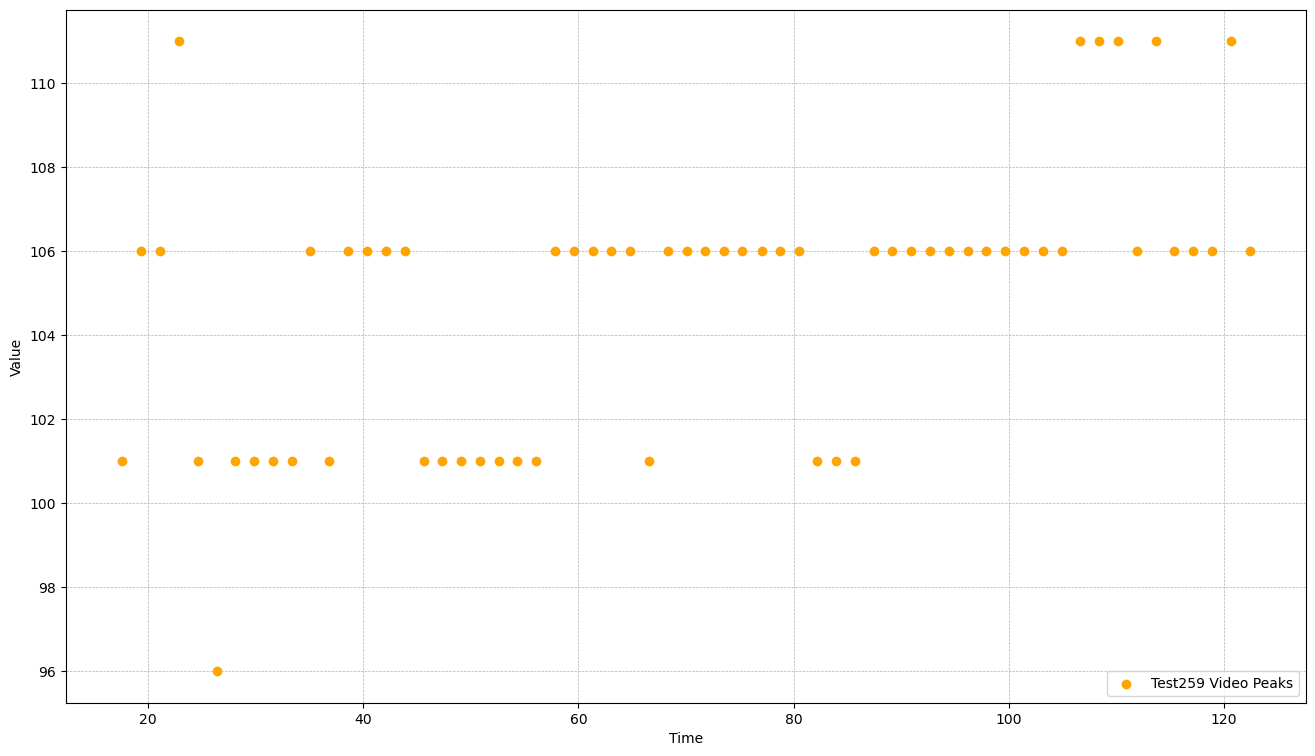

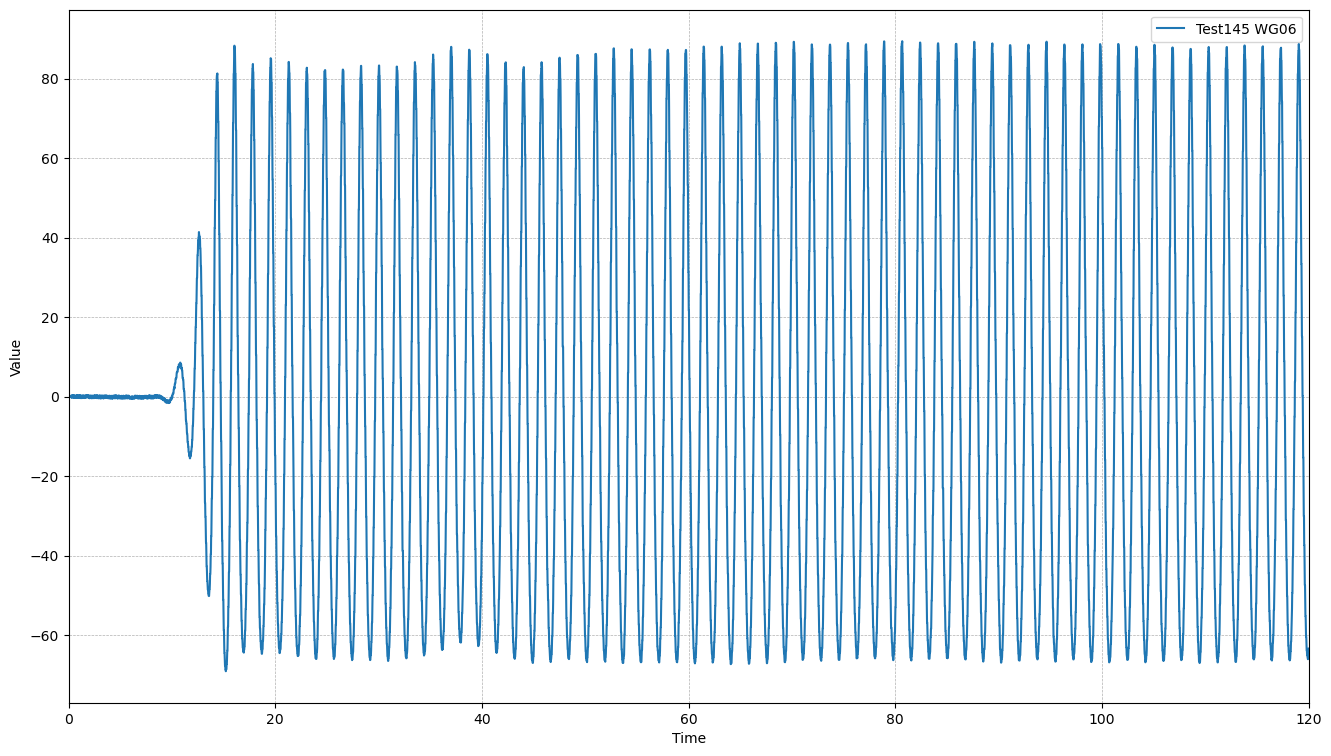

In [41]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG04'].plot(linestyle='-', label=f"{testName1} WG04")
# ds2['WG04'].plot(linestyle='-', label=f"{testName2} WG04")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

peaks_tRange = (30, 60)
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG05'].plot(linestyle='-', label=f"{testName1} WG05")
# ds2['WG05'].plot(linestyle='-', label=f"{testName2} WG05")
plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'], 
    color='orange', label=f'{testName_peaks} Video Peaks')
# ax.axvline(x=peaks_tRange[0], color='b', linestyle='--')
# ax.axvline(x=peaks_tRange[1], color='b', linestyle='--')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
plt.ylim(-100, 150)
set_min_plot_prop(ax)
ax.set_ylabel("Wave Elevation (mm)")
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'],
    color='orange', label=f'{testName_peaks} Video Peaks')
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG06'].plot(linestyle='-', label=f"{testName1} WG06")
# ds2['WG06'].plot(linestyle='-', label=f"{testName2} WG06")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG07 - WG09

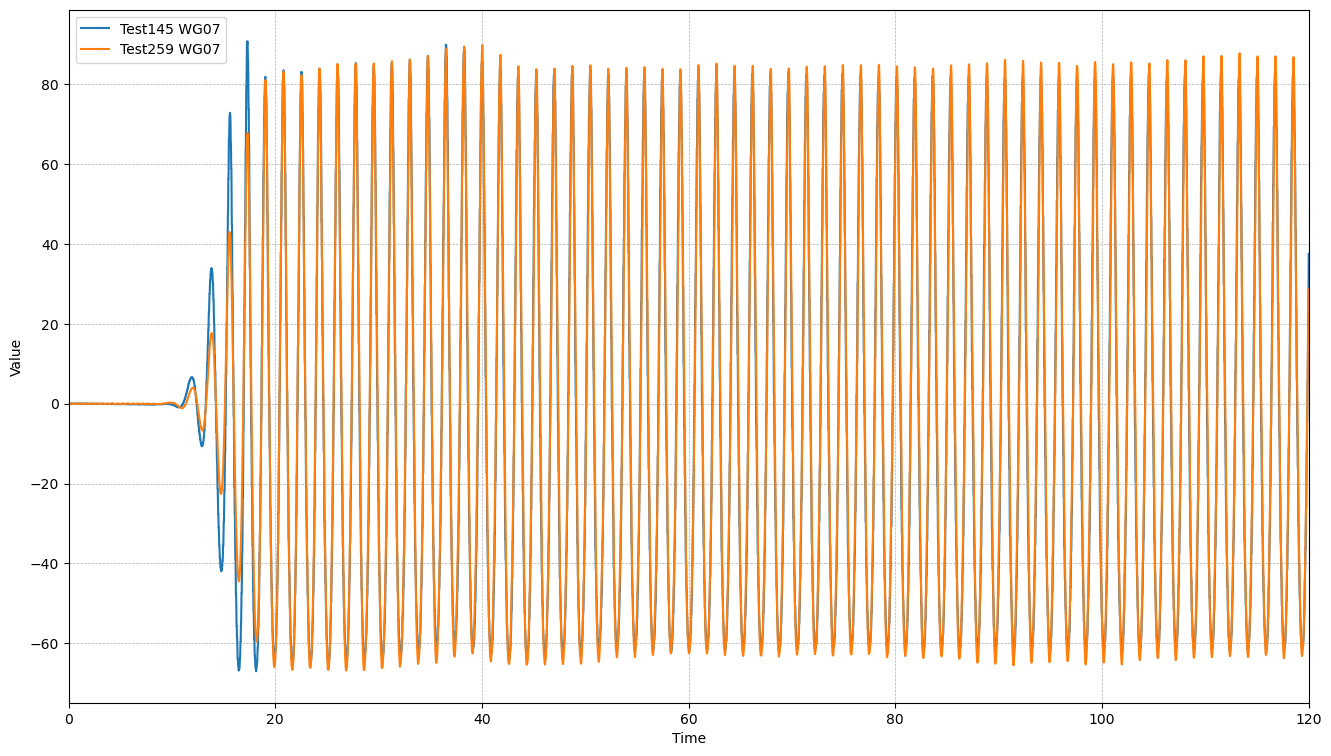

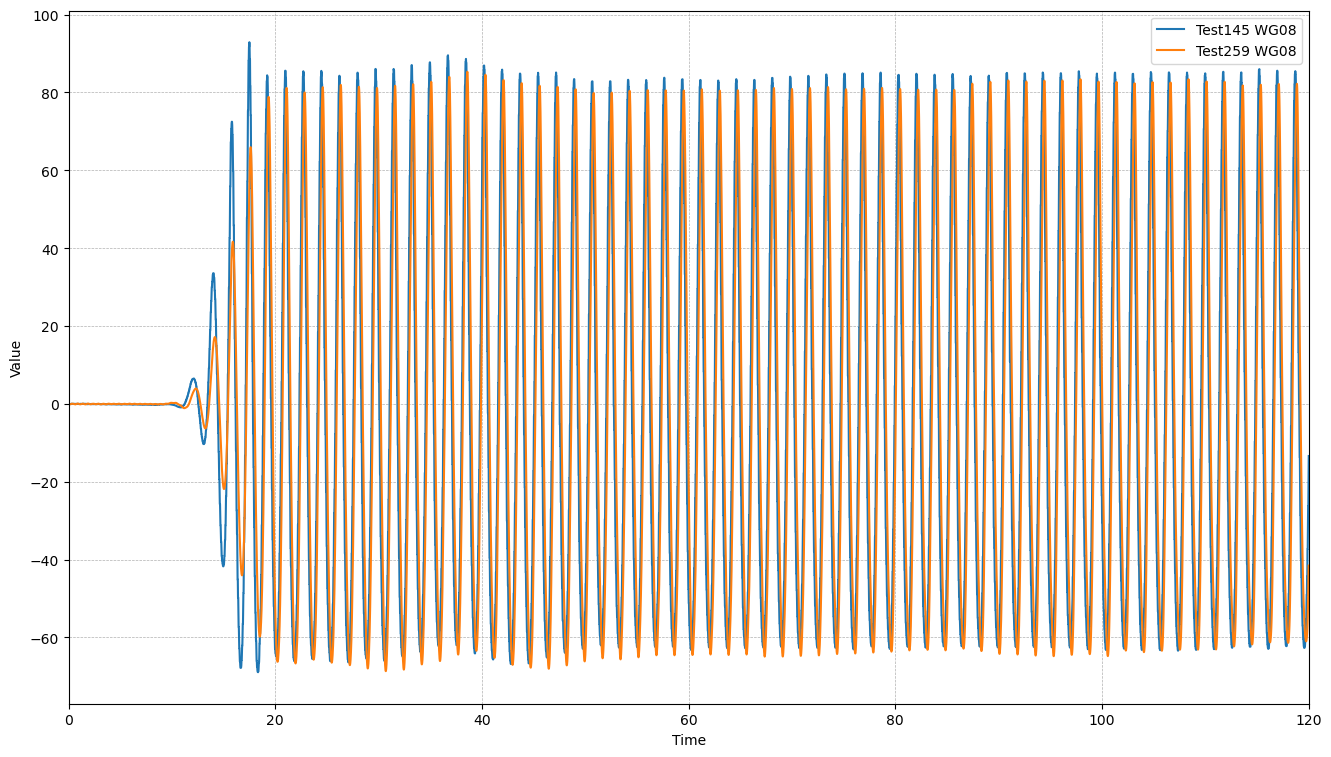

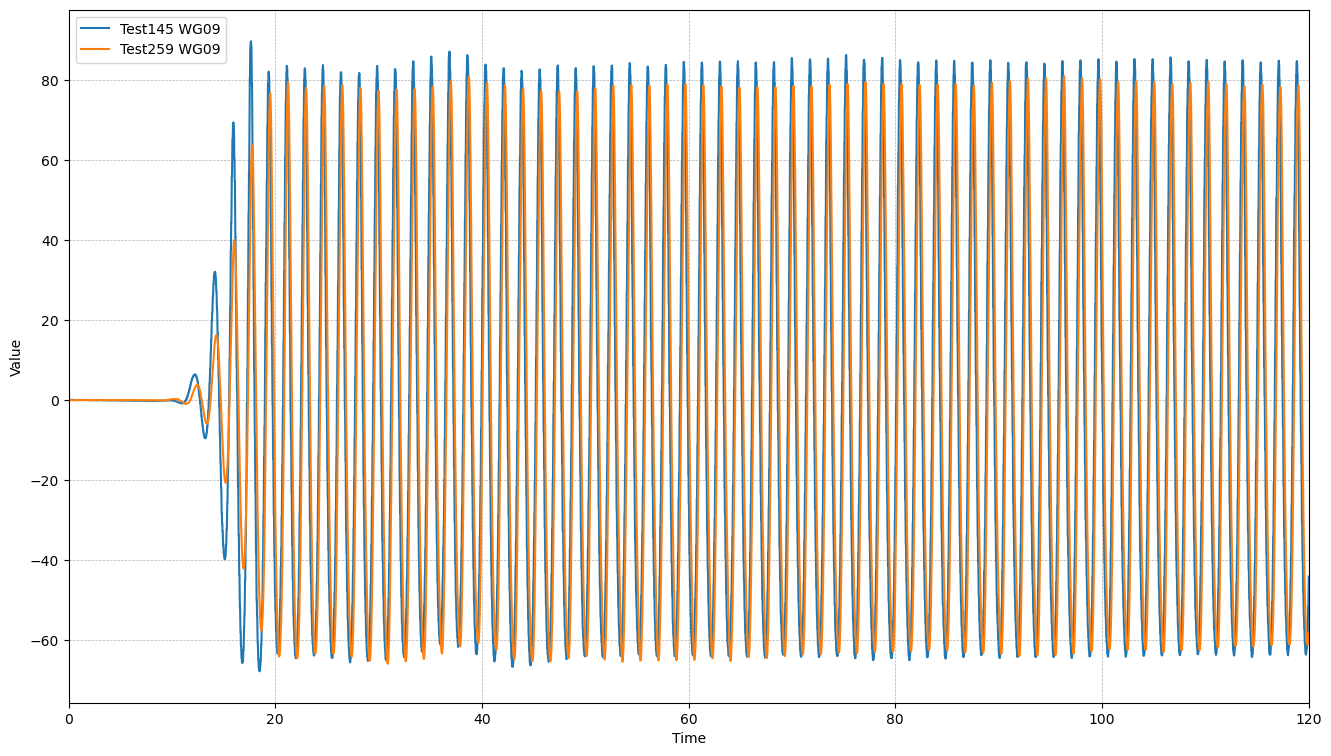

In [42]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG07'].plot(linestyle='-', label=f"{testName1} WG07")
ds2['WG07'].plot(linestyle='-', label=f"{testName2} WG07")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG08'].plot(linestyle='-', label=f"{testName1} WG08")
ds2['WG08'].plot(linestyle='-', label=f"{testName2} WG08")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG09'].plot(linestyle='-', label=f"{testName1} WG09")
ds2['WG09'].plot(linestyle='-', label=f"{testName2} WG09")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

## Boxplot

In [43]:
peaks_tRange = (30, 60)
ds1_cut = ds1.sel(Time=slice(peaks_tRange[0], peaks_tRange[1]))

# Empty-tank Crest Peaks
peaks_distance = testProp1['wavePeriod']*testProp1['fSampling']*0.7
wg = 'WG05'
crest_peak_idx, _ =  sp.signal.find_peaks(ds1_cut[wg], distance = peaks_distance)   
crest_peak = ds1_cut[wg][crest_peak_idx]
print(f"Crest Peaks at indices: {crest_peak}") 

Crest Peaks at indices: <xarray.DataArray 'WG05' (Time: 17)> Size: 136B
array([83.77648284, 84.31068284, 86.34718284, 88.50058284, 89.10148284,
       88.04148284, 86.13848284, 84.46928284, 85.08688284, 86.38888284,
       86.74778284, 86.42228284, 87.54908284, 87.96638284, 87.79108284,
       87.52398284, 87.86618284])
Coordinates:
  * Time     (Time) float64 136B 31.73 33.47 35.23 36.97 ... 56.21 57.93 59.67


In [44]:
runup_idx = (testpeaks_peaks['time_s'] >= peaks_tRange[0]) & (testpeaks_peaks['time_s'] <= peaks_tRange[1])
runup_peaks = testpeaks_peaks[runup_idx]
print(f"Video Runup Peaks at indices: {runup_peaks}")

# runup_idx = range(10,41)
# runup_peaks = testpeaks_peaks.iloc[runup_idx]
# print(f"Video Runup Peaks at indices: {runup_peaks}")

Video Runup Peaks at indices:      Test_ID event_type  event_id     time_s  value
413  Test259       peak       9.0  31.617319    101
414  Test259       peak      10.0  33.368319    101
415  Test259       peak      11.0  35.104319    106
416  Test259       peak      12.0  36.872319    101
417  Test259       peak      13.0  38.607319    106
418  Test259       peak      14.0  40.359319    106
419  Test259       peak      15.0  42.111319    106
420  Test259       peak      16.0  43.862319    106
421  Test259       peak      17.0  45.614319    101
422  Test259       peak      18.0  47.349319    101
423  Test259       peak      19.0  49.084319    101
424  Test259       peak      20.0  50.836319    101
425  Test259       peak      21.0  52.604319    101
426  Test259       peak      22.0  54.323319    101
427  Test259       peak      23.0  56.075319    101
428  Test259       peak      24.0  57.826319    106
429  Test259       peak      25.0  59.595319    106


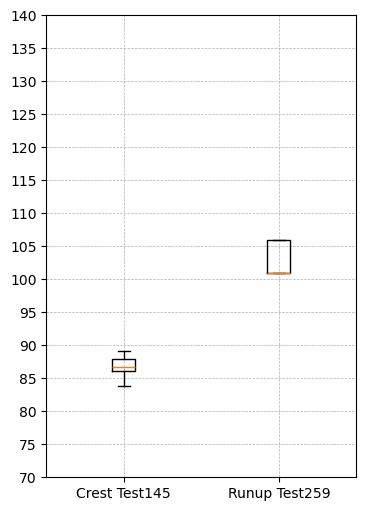

Crest Peaks: 86.75 mm = 0.58 H
Runup Peaks: 101.00 mm = 0.67 H
R/C = 1.16


In [45]:
my_dict = {
    f'Crest {testName1}': crest_peak.values, 
    f'Runup {testName2}': runup_peaks['value'].values }

fig, ax = plt.subplots(figsize=(4,6))
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yticks(np.arange(70, 145, 5))
ax.set_ylim(70, 140)
# ax.legend()
plt.show()

crest_peak_ref = np.median(crest_peak.values)
runup_peaks_ref = np.median(runup_peaks['value'].values)
print(f'Crest Peaks: {crest_peak_ref:.2f} mm =',
    f'{crest_peak_ref/1000/testProp1["waveAmplitude"]:.2f} H')
print(f'Runup Peaks: {runup_peaks_ref:.2f} mm =', 
    f'{runup_peaks_ref/1000/testProp1["waveAmplitude"]:.2f} H')
print(f'R/C = {runup_peaks_ref/crest_peak_ref:.2f}')

## Find maxima

In [46]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [47]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

print("DS1 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut)
print()

print("DS2 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut)  

DS1 Signal Min/Max in selected time range:
Signal: WG01   Max Value: 87.13848431818181 at :  106.9490   Min Value: -67.26751568181818 at :  55.4694
Signal: WG02   Max Value: 88.49680090909091 at :  40.7894   Min Value: -70.21699909090908 at :  13.6895
Signal: WG03   Max Value: 86.80065511363637 at :  39.2294   Min Value: -67.65644488636363 at :  13.8895
Signal: WG04   Max Value: 88.1465175 at :  80.5694   Min Value: -68.7392825 at :  15.1295
Signal: WG05   Max Value: 89.69408284090909 at :  80.5894   Min Value: -69.95561715909092 at :  15.1695
Signal: WG06   Max Value: 89.39415329545456 at :  80.6694   Min Value: -69.06044670454546 at :  15.2095
Signal: WG07   Max Value: 90.73614056818181 at :  17.2895   Min Value: -66.99075943181819 at :  18.1295
Signal: WG08   Max Value: 92.91173068181818 at :  17.4895   Min Value: -68.92666931818181 at :  18.3295
Signal: WG09   Max Value: 89.78009806818183 at :  17.6495   Min Value: -67.87280193181817 at :  18.4695
Signal: LED-chan100   Max Value: 0

## Plot Spec

In [48]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 1500
Least count Hz = 0.03333333333333333
Max Freq (Half band) Hz = 25.0
Sample Len = 61440
Least count Hz = 0.03333333333333333
Max Freq (Half band) Hz = 1024.0


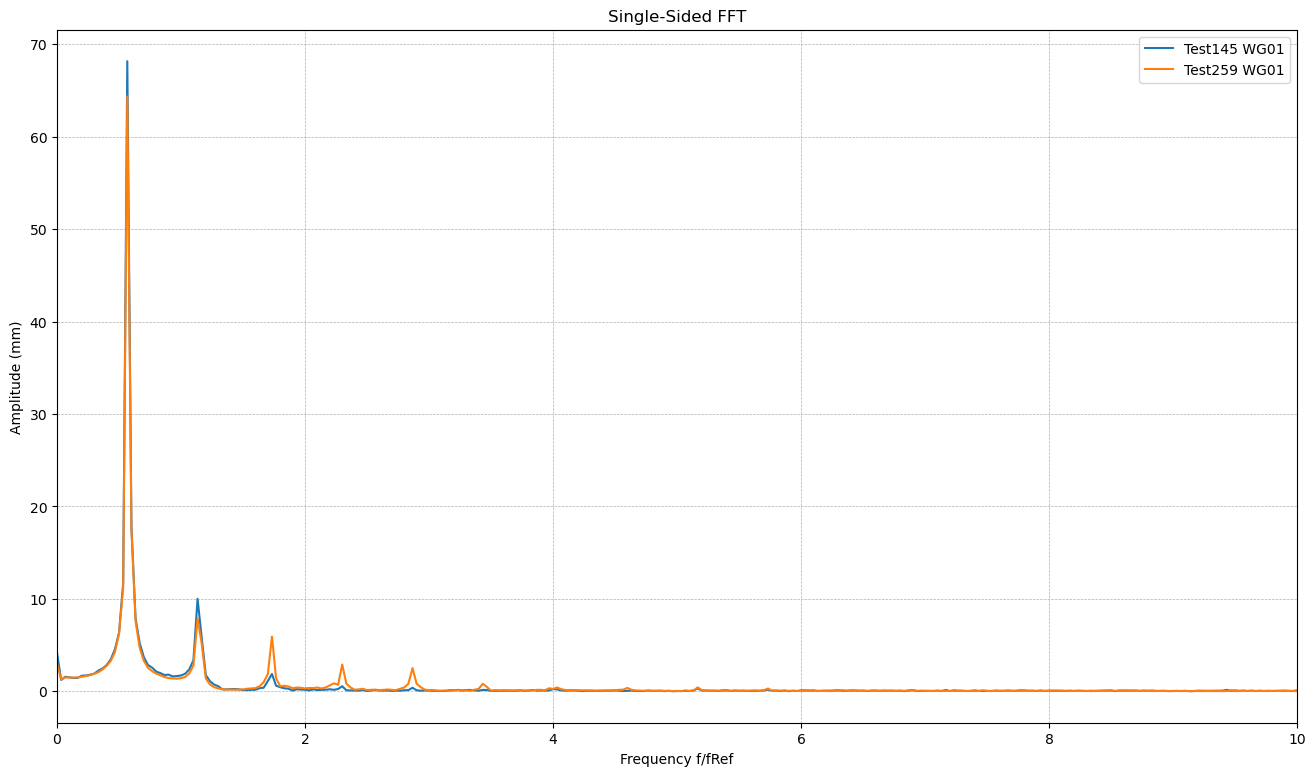

In [49]:
tmin = 50
tmax = 80

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

fSampling1 = loaded_mat1['TestProperties']['fSampling']
fSampling2 = loaded_mat2['TestProperties']['fSampling']

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, f"{testName1} WG01")
# getSpec(ds1_cut['WG05'], fSampling1, ax, xlim, f"{testName1} WG05")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, f"{testName1} WG07")
getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, f"{testName2} WG01")

pass